In [1]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())


2.10.0+cpu
CUDA available: False


### Second Part: UL Data Loading and Pre-processing

The dataset is loaded from a pre-cleaned CSV file. Only two core system-level features are used as model inputs:
- `airtime`
- `selected_mcs`

The target variable is `pm_power`, representing power consumption.


In [16]:
# ============================================================
# CELL 1 — Data Preparation & Group-wise Splitting
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# ------------------------------------------------------------
# 1) Load dataset
# ------------------------------------------------------------
# This dataset already includes UL samples with fixed conditions
# (traffic_load, BW, nRBs, clockspeed)
df = pd.read_csv("clean_ul_with_conditions2.csv")


# ------------------------------------------------------------
# 2) Define feature sets
# Each experiment isolates one key variable while keeping
# system parameters as additional inputs.
# ------------------------------------------------------------
FEATURE_SETS = {
    "gain":   ["txgain", "traffic_load", "BW", "nRBs", "clockspeed"],
    "mcs":    ["selected_mcs", "traffic_load", "BW", "nRBs", "clockspeed"],
    "airtime":["airtime", "traffic_load", "BW", "nRBs", "clockspeed"],
}

target_col = "pm_power"


# ------------------------------------------------------------
# 3) Numeric cleaning function
# Ensures:
#   - No missing values
#   - All columns numeric
#   - Target strictly positive (for MRE stability)
# ------------------------------------------------------------
def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()

    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")

    d = d.dropna(subset=cols_needed).copy()

    # Ensure target positive (avoids division instability in MRE)
    d = d[d[target_col] > 0].copy()

    return d


# ------------------------------------------------------------
# 4) Group-wise split
# For each unique value of group_col:
#   - 80% train
#   - 20% test
#   - Within train: 10% validation
#
# This ensures each parameter value appears in all sets.
# ------------------------------------------------------------
def groupwise_split_df(
    d,
    group_col,
    train_ratio=0.8,
    val_ratio_within_train=0.1,
    seed=42,
    min_group_size=5
):
    train_parts, val_parts, test_parts = [], [], []
    d2 = d.dropna(subset=[group_col]).copy()

    for gval, gdf in d2.groupby(group_col):

        # Skip very small groups
        if len(gdf) < min_group_size:
            continue

        # 80% train / 20% test
        g_train, g_test = train_test_split(
            gdf,
            test_size=(1 - train_ratio),
            random_state=seed
        )

        # Split validation from training portion
        g_train, g_val = train_test_split(
            g_train,
            test_size=val_ratio_within_train,
            random_state=seed
        )

        train_parts.append(g_train)
        val_parts.append(g_val)
        test_parts.append(g_test)

    if len(train_parts) == 0:
        raise ValueError(
            f"No groups large enough after grouping by '{group_col}'. "
            f"Try reducing min_group_size."
        )

    train_df = pd.concat(train_parts, ignore_index=True)
    val_df   = pd.concat(val_parts,   ignore_index=True)
    test_df  = pd.concat(test_parts,  ignore_index=True)

    return train_df, val_df, test_df


In [17]:
# ============================================================
# CELL 2 — Model Definition, Training, Evaluation
# ============================================================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ------------------------------------------------------------
# 1) Dataset wrapper for PyTorch
# ------------------------------------------------------------
class TabularDataset(Dataset):
    """
    Simple PyTorch Dataset for tabular regression.
    """
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ------------------------------------------------------------
# 2) Baseline DNN (Model 1)
# 3 hidden layers: 64 → 64 → 32
# ------------------------------------------------------------
class BaselineDNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),

            nn.Linear(64, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# ------------------------------------------------------------
# 3) Mean Relative Error (percentage)
# ------------------------------------------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(
        np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100
    )


# ------------------------------------------------------------
# 4) Training & Evaluation Function
# ------------------------------------------------------------
def train_eval_model1(
    train_df,
    val_df,
    test_df,
    feature_cols,
    target_col,
    epochs=100,
    batch_size=64,
    lr=1e-3,
    seed=42,
    verbose_every=10
):

    # Reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Extract arrays
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values

    # --------------------------------------------------------
    # Standardization (fit ONLY on training set)
    # --------------------------------------------------------
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    # DataLoaders
    train_loader = DataLoader(
        TabularDataset(X_train_s, y_train),
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        TabularDataset(X_val_s, y_val),
        batch_size=batch_size,
        shuffle=False
    )

    test_loader = DataLoader(
        TabularDataset(X_test_s, y_test),
        batch_size=batch_size,
        shuffle=False
    )

    # Model initialization
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = BaselineDNN(in_dim=len(feature_cols)).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val_loss = float("inf")
    best_state = None

    print(f"\n[Model1] Training | features={feature_cols}")
    print(f"Train/Val/Test sizes: {len(train_df)}/{len(val_df)}/{len(test_df)}")

    # --------------------------------------------------------
    # Training loop
    # --------------------------------------------------------
    for epoch in range(1, epochs + 1):

        # ---- Training phase ----
        model.train()
        train_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * len(xb)

        train_loss /= len(train_loader.dataset)

        # ---- Validation phase ----
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item() * len(xb)

        val_loss /= len(val_loader.dataset)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {
                k: v.detach().cpu().clone()
                for k, v in model.state_dict().items()
            }

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | "
                  f"Train MSE {train_loss:.6f} | "
                  f"Val MSE {val_loss:.6f}")

    # Load best weights
    model.load_state_dict(best_state)
    print("Best validation MSE:", best_val_loss)

    # --------------------------------------------------------
    # Test evaluation
    # --------------------------------------------------------
    model.eval()
    y_true_list, y_pred_list = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy().reshape(-1)

            y_pred_list.append(pred)
            y_true_list.append(yb.numpy().reshape(-1))

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "mre_pct": mre,
        "y_true": y_true,
        "y_pred": y_pred,
        "model":model,
        "scaler":scaler,
    }


# ------------------------------------------------------------
# 5) Main experiment loop
# ------------------------------------------------------------
results = []
test_outputs_m1 = {}
trained_models = {}

for feat_name, feature_cols in FEATURE_SETS.items():

    print("\n===================================")
    print(f"Feature set: {feat_name}")
    print("===================================")

    cols_needed = feature_cols + [target_col]

    d = clean_numeric_df(df, cols_needed, target_col)

    train_df, val_df, test_df = groupwise_split_df(
        d,
        group_col=feature_cols[0],
        seed=42,
        min_group_size=5
    )

    out = train_eval_model1(
        train_df,
        val_df,
        test_df,
        feature_cols,
        target_col
    )

    test_outputs_m1[feat_name] = {
        "test_df": test_df.copy(),
        "y_true": out["y_true"],
        "y_pred_m1": out["y_pred"],
    }

    results.append({
        "feature_set": feat_name,
        "model": "Model1 (BaselineDNN)",
        "features": ",".join(feature_cols),
        "MSE": out["mse"],
        "RMSE": out["rmse"],
        "MAE": out["mae"],
        "MRE(%)": out["mre_pct"],
        "n_train": len(train_df),
        "n_val": len(val_df),
        "n_test": len(test_df),
    })

    trained_models.setdefault(feat_name, {})
    trained_models[feat_name]["m1"] = {"model": out["model"], "scaler": out["scaler"]}



results_df = pd.DataFrame(results)

print("\n=== Final Results ===")
display(results_df)

print("\n=== Sorted by MSE ===")
print(results_df.sort_values("MSE"))



Feature set: gain

[Model1] Training | features=['txgain', 'traffic_load', 'BW', 'nRBs', 'clockspeed']
Train/Val/Test sizes: 4135/476/1158
Epoch 001 | Train MSE 89.426472 | Val MSE 19.877669
Epoch 010 | Train MSE 0.282300 | Val MSE 0.359586
Epoch 020 | Train MSE 0.273657 | Val MSE 0.347676
Epoch 030 | Train MSE 0.272981 | Val MSE 0.332597
Epoch 040 | Train MSE 0.268459 | Val MSE 0.329021
Epoch 050 | Train MSE 0.266465 | Val MSE 0.332429
Epoch 060 | Train MSE 0.269577 | Val MSE 0.369560
Epoch 070 | Train MSE 0.271569 | Val MSE 0.342491
Epoch 080 | Train MSE 0.261749 | Val MSE 0.321478
Epoch 090 | Train MSE 0.265061 | Val MSE 0.315139
Epoch 100 | Train MSE 0.263037 | Val MSE 0.325866
Best validation MSE: 0.3100525566509792

Feature set: mcs

[Model1] Training | features=['selected_mcs', 'traffic_load', 'BW', 'nRBs', 'clockspeed']
Train/Val/Test sizes: 4147/466/1156
Epoch 001 | Train MSE 89.740457 | Val MSE 17.968166
Epoch 010 | Train MSE 0.210271 | Val MSE 0.197001
Epoch 020 | Train MSE

,feature_set,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,Model1 (BaselineDNN),"txgain,traffic_load,BW,nRBs,clockspeed",0.215308,0.464013,0.361243,3.106509,4135,476,1158
1,mcs,Model1 (BaselineDNN),"selected_mcs,traffic_load,BW,nRBs,clockspeed",0.216404,0.465193,0.354558,3.027429,4147,466,1156
2,airtime,Model1 (BaselineDNN),"airtime,traffic_load,BW,nRBs,clockspeed",0.204759,0.452503,0.349318,3.006910,4145,465,1159



=== Sorted by MSE ===
  feature_set                 model  \
2     airtime  Model1 (BaselineDNN)   
0        gain  Model1 (BaselineDNN)   
1         mcs  Model1 (BaselineDNN)   

                                       features       MSE      RMSE       MAE  \
2       airtime,traffic_load,BW,nRBs,clockspeed  0.204759  0.452503  0.349318   
0        txgain,traffic_load,BW,nRBs,clockspeed  0.215308  0.464013  0.361243   
1  selected_mcs,traffic_load,BW,nRBs,clockspeed  0.216404  0.465193  0.354558   

     MRE(%)  n_train  n_val  n_test  
2  3.006910     4145    465    1159  
0  3.106509     4135    476    1158  
1  3.027429     4147    466    1156  


## Model 2: Regularised Deep Neural Network (DNN)

To address the overfitting observed in the baseline model, we implement a regularised DNN architecture following the Cam-Ready paper design.

### Architecture

- Input layer: number of neurons = number of input features  
- Hidden Layer 1: 128 neurons  
- Hidden Layer 2: 64 neurons  
- Hidden Layer 3: 32 neurons  
- Output layer: 1 neuron (predicting continuous power consumption)

### Regularisation Techniques

- ReLU activation
- Batch Normalisation before activation
- Dropout (p = 0.3) after each hidden layer
- L2 weight decay (λ = 0.01)
- Adam optimizer
- MSE loss function
- Batch size = 64



In [18]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# ------------------------------------------------------------
# 1) Helper: numeric cleaning for the current feature set
#    - drop NaNs
#    - coerce to numeric
#    - keep target positive (for stable MRE)
# ------------------------------------------------------------
def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()
    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()
    return d


# ------------------------------------------------------------
# 2) PyTorch Dataset for tabular regression
# ------------------------------------------------------------
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# =========================
# 1) Model2 definition (RegularizedDNN)
# =========================
class RegularizedDNN(nn.Module):
    def __init__(self, input_dim, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


# =========================
# 2) Train + Evaluate Model2 (same style as Model1)
# =========================
def train_eval_model2(
    train_df, val_df, test_df,
    feature_cols, target_col,
    epochs=200, batch_size=64, lr=1e-3, weight_decay=1e-2,
    seed=42, verbose_every=10
):
    # Reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Build arrays
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values

    # Scale (fit only on train)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    # Torch tensors
    X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
    y_train_t = torch.tensor(y_train,   dtype=torch.float32).view(-1, 1)
    X_val_t   = torch.tensor(X_val_s,   dtype=torch.float32)
    y_val_t   = torch.tensor(y_val,     dtype=torch.float32).view(-1, 1)
    X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,    dtype=torch.float32).view(-1, 1)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = RegularizedDNN(input_dim=X_train_s.shape[1], dropout=0.3).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_state = None

    print(f"\n[Model2] Training | features={feature_cols} | device={device}")
    print(f"Train/Val/Test sizes: {len(train_df)}/{len(val_df)}/{len(test_df)}")
    print(f"Scaled shapes: {X_train_s.shape}, {X_val_s.shape}, {X_test_s.shape}")
    print(f"epochs={epochs}, batch={batch_size}, lr={lr}, weight_decay={weight_decay}, dropout=0.3")

    for epoch in range(1, epochs + 1):
        # ---- train (mini-batch like your original model2) ----
        model.train()
        perm = torch.randperm(X_train_t.size(0))

        for i in range(0, X_train_t.size(0), batch_size):
            idx = perm[i:i+batch_size]
            xb = X_train_t[idx].to(device)
            yb = y_train_t[idx].to(device)

            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        # ---- epoch-end evaluation: train MSE & val MSE ----
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_t.to(device))
            val_pred   = model(X_val_t.to(device))
            train_mse  = criterion(train_pred, y_train_t.to(device)).item()
            val_mse    = criterion(val_pred,   y_val_t.to(device)).item()

        if val_mse < best_val:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | train MSE {train_mse:.6f} | val MSE {val_mse:.6f}")

    # load best checkpoint
    model.load_state_dict(best_state)
    print("Best val MSE:", best_val)

    # ---- test prediction ----
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_t.to(device)).cpu().numpy().reshape(-1)
    y_true = y_test_t.numpy().reshape(-1)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": mse, "rmse": rmse, "mae": mae, "mre_pct": mre,
        "y_true": y_true, "y_pred": y_pred,
        "scaler": scaler, "model": model
    }


# =========================
# 3) Main: loop feature sets -> train Model2 -> results table
# =========================


results = []
test_outputs_m2 = {}

for feat_name, feature_cols in FEATURE_SETS.items():
    print(f"\n==============================")
    print(f"Feature set: {feat_name} -> {feature_cols}")
    print(f"==============================")

    cols_needed = feature_cols + [target_col]
    d = df.dropna(subset=cols_needed).copy()

    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()

    group_col = feature_cols[0]
    train_df, val_df, test_df = groupwise_split_df(d, group_col=group_col, seed=42, min_group_size=5)

    out = train_eval_model2(
        train_df, val_df, test_df,
        feature_cols=feature_cols,
        target_col=target_col,
        epochs=100, batch_size=64, lr=1e-3, weight_decay=1e-2,
        seed=42, verbose_every=10
    )

    # Save test predictions for plotting later
    test_outputs_m2[feat_name] = {
        "test_df": test_df.copy(),
        "y_true": out["y_true"],
        "y_pred_m2": out["y_pred"]
    }

    results.append({
        "feature_set": feat_name,
        "model": "Model2 (RegularizedDNN)",
        "features": ",".join(feature_cols),
        "MSE": out["mse"],
        "RMSE": out["rmse"],
        "MAE": out["mae"],
        "MRE(%)": out["mre_pct"],
        "n_train": len(train_df),
        "n_val": len(val_df),
        "n_test": len(test_df),
    })

    trained_models.setdefault(feat_name, {})
    trained_models[feat_name]["m2"] = {"model": out["model"], "scaler": out["scaler"]}


results_df = pd.DataFrame(results)
display(results_df)

print("\n=== Summary (sorted by MSE) ===")
print(results_df.sort_values("MSE")[["feature_set","model","MSE","RMSE","MAE","MRE(%)","n_train","n_val","n_test"]])



Feature set: gain -> ['txgain', 'traffic_load', 'BW', 'nRBs', 'clockspeed']

[Model2] Training | features=['txgain', 'traffic_load', 'BW', 'nRBs', 'clockspeed'] | device=cpu
Train/Val/Test sizes: 4135/476/1158
Scaled shapes: (4135, 5), (476, 5), (1158, 5)
epochs=100, batch=64, lr=0.001, weight_decay=0.01, dropout=0.3
Epoch 001 | train MSE 116.924484 | val MSE 118.183067
Epoch 010 | train MSE 0.923649 | val MSE 1.068319
Epoch 020 | train MSE 0.618769 | val MSE 0.834646
Epoch 030 | train MSE 0.482927 | val MSE 0.612343
Epoch 040 | train MSE 0.497978 | val MSE 0.620850
Epoch 050 | train MSE 0.380832 | val MSE 0.491232
Epoch 060 | train MSE 0.382571 | val MSE 0.477480
Epoch 070 | train MSE 0.422047 | val MSE 0.546469
Epoch 080 | train MSE 0.407605 | val MSE 0.534102
Epoch 090 | train MSE 0.409199 | val MSE 0.520605
Epoch 100 | train MSE 0.379764 | val MSE 0.468714
Best val MSE: 0.4246833920478821

Feature set: mcs -> ['selected_mcs', 'traffic_load', 'BW', 'nRBs', 'clockspeed']

[Model2] T

,feature_set,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,Model2 (RegularizedDNN),"txgain,traffic_load,BW,nRBs,clockspeed",0.310072,0.556841,0.412925,3.483849,4135,476,1158
1,mcs,Model2 (RegularizedDNN),"selected_mcs,traffic_load,BW,nRBs,clockspeed",0.267207,0.516920,0.403422,3.439115,4147,466,1156
2,airtime,Model2 (RegularizedDNN),"airtime,traffic_load,BW,nRBs,clockspeed",0.227394,0.476859,0.360446,3.083055,4145,465,1159



=== Summary (sorted by MSE) ===
  feature_set                    model       MSE      RMSE       MAE  \
2     airtime  Model2 (RegularizedDNN)  0.227394  0.476859  0.360446   
1         mcs  Model2 (RegularizedDNN)  0.267207  0.516920  0.403422   
0        gain  Model2 (RegularizedDNN)  0.310072  0.556841  0.412925   

     MRE(%)  n_train  n_val  n_test  
2  3.083055     4145    465    1159  
1  3.439115     4147    466    1156  
0  3.483849     4135    476    1158  


## Model 3: Hybrid DNN–XGBoost (DNN Feature Extractor + XGBoost Regressor)

This model follows the hybrid pipeline described in the Cam-Ready paper.  
The key idea is to split the learning process into two stages:

1) A DNN is trained as a **feature extractor** to learn compact latent representations.  
2) The DNN is frozen, and a separate **XGBoost regressor** is trained on the extracted embeddings.

### DNN Feature Extractor Architecture
- Dense layers: 587 → 261 → 186 → 99
- Bottleneck embedding layer: 16 neurons
- Output head (for DNN training): 1 neuron (MSE loss)

### XGBoost Regressor (trained on embeddings)
- max_depth = 5
- n_estimators = 256
- learning_rate = 0.22


In [19]:
# ============================================================
# CELL 4 — Model3 (Hybrid DNN Feature Extractor + XGBoost)
# NOTE:
#   This cell assumes the following are already defined earlier:
#     - df              : loaded DataFrame
#     - FEATURE_SETS    : dict of feature sets
#     - target_col      : target column name (string)
#     - groupwise_split_df(d, group_col, ...) : split function
#     - mean_relative_error(y_true, y_pred)   : metric function
# ============================================================

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor


# ------------------------------------------------------------
# 1) Data cleaning helper (local to this cell)
#    - drop NaNs
#    - convert to numeric
#    - keep target strictly positive (for MRE stability)
# ------------------------------------------------------------
def clean_numeric_df(df, cols_needed, target_col):
    d = df.dropna(subset=cols_needed).copy()
    for c in cols_needed:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=cols_needed).copy()
    d = d[d[target_col] > 0].copy()
    return d


# ------------------------------------------------------------
# 2) PyTorch Dataset for tabular regression
# ------------------------------------------------------------
class TabularDataset(Dataset):
    """
    Simple dataset wrapper for (X, y) tabular regression.
    """
    def __init__(self, X, y):
        self.X = torch.tensor(np.asarray(X), dtype=torch.float32)
        self.y = torch.tensor(np.asarray(y), dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ------------------------------------------------------------
# 3) Model3: Hybrid feature extractor DNN
#    - The DNN produces a low-dimensional embedding (bottleneck).
#    - A simple linear regression head is used to train end-to-end.
#    - After training, we extract embeddings and feed them to XGBoost.
# ------------------------------------------------------------
class HybridFeatureExtractor(nn.Module):
    """
    DNN feature extractor with a 16-dim bottleneck embedding.
    The regression head enables end-to-end training using MSE.
    """
    def __init__(self, input_dim, emb_dim=16):
        super().__init__()

        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, 587), nn.ReLU(),
            nn.Linear(587, 261), nn.ReLU(),
            nn.Linear(261, 186), nn.ReLU(),
            nn.Linear(186, 99),  nn.ReLU(),
            nn.Linear(99, emb_dim)  # bottleneck embedding
        )

        self.reg_head = nn.Linear(emb_dim, 1)

    def forward(self, x):
        emb = self.feature_net(x)
        out = self.reg_head(emb)
        return out, emb


# ------------------------------------------------------------
# 4) Train + Evaluate Model3
#    Stage A: Train DNN end-to-end on (X -> power)
#    Stage B: Freeze DNN, extract embeddings, train XGBoost on embeddings
# ------------------------------------------------------------
def train_eval_model3(
    train_df, val_df, test_df,
    feature_cols, target_col,
    epochs=200, batch_size=64, lr=1e-3,
    dnn_weight_decay=1e-2,
    emb_dim=16,
    seed=42,
    verbose_every=10,
    patience=20,
    min_delta=1e-6,
    xgb_params=None
):
    # ---- reproducibility ----
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # ---- extract raw arrays ----
    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values

    X_val   = val_df[feature_cols].values
    y_val   = val_df[target_col].values

    X_test  = test_df[feature_cols].values
    y_test  = test_df[target_col].values

    # ---- scale features (fit ONLY on train) ----
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    # ---- dataloaders for mini-batch training ----
    train_loader = DataLoader(
        TabularDataset(X_train_s, y_train),
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        TabularDataset(X_val_s, y_val),
        batch_size=batch_size,
        shuffle=False
    )
    test_loader = DataLoader(
        TabularDataset(X_test_s, y_test),
        batch_size=batch_size,
        shuffle=False
    )

    # ---- initialize DNN feature extractor ----
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dnn = HybridFeatureExtractor(input_dim=len(feature_cols), emb_dim=emb_dim).to(device)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(dnn.parameters(), lr=lr, weight_decay=dnn_weight_decay)

    best_val = float("inf")
    best_state = None
    no_improve = 0

    print(f"\n[Model3] Stage A: DNN training | features={feature_cols} | device={device}")
    print(f"Train/Val/Test sizes: {len(train_df)}/{len(val_df)}/{len(test_df)}")
    print(f"Scaled shapes: {X_train_s.shape}, {X_val_s.shape}, {X_test_s.shape}")
    print(f"epochs={epochs}, batch={batch_size}, lr={lr}, weight_decay={dnn_weight_decay}, emb_dim={emb_dim}")

    # ----------------------------
    # Stage A: Train DNN end-to-end
    # ----------------------------
    for epoch in range(1, epochs + 1):

        # ---- train epoch ----
        dnn.train()
        train_loss_sum = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            pred, _ = dnn(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * len(xb)

        train_mse = train_loss_sum / len(train_loader.dataset)

        # ---- validation epoch ----
        dnn.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred, _ = dnn(xb)
                val_loss_sum += loss_fn(pred, yb).item() * len(xb)

        val_mse = val_loss_sum / len(val_loader.dataset)

        # ---- checkpoint + early stopping ----
        if val_mse < best_val - min_delta:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in dnn.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | train MSE {train_mse:.6f} | val MSE {val_mse:.6f} | no_improve={no_improve}")

        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
            break

    # Load best DNN
    dnn.load_state_dict(best_state)
    print("Best val MSE (DNN stage):", best_val)

    # -----------------------------------------
    # Stage B: Extract embeddings for XGBoost
    # -----------------------------------------
    def extract_embeddings(loader):
        dnn.eval()
        embs, ys = [], []
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device)
                _, emb = dnn(xb)
                embs.append(emb.cpu().numpy())
                ys.append(yb.numpy().reshape(-1))
        return np.vstack(embs), np.concatenate(ys)

    emb_train, y_train_1d = extract_embeddings(train_loader)
    emb_test,  y_test_1d  = extract_embeddings(test_loader)

    print("Embedding shape (train):", emb_train.shape)
    print("Embedding shape (test) :", emb_test.shape)

    # Default XGBoost hyperparameters if not provided
    if xgb_params is None:
        xgb_params = dict(
            max_depth=5,
            n_estimators=256,
            learning_rate=0.22,
            objective="reg:squarederror",
            random_state=seed,
            n_jobs=-1
        )

    print("\n[Model3] Stage B: XGBoost training on embeddings")
    xgb = XGBRegressor(**xgb_params)
    xgb.fit(emb_train, y_train_1d)

    # ---- inference ----
    y_pred = xgb.predict(emb_test).reshape(-1)
    y_true = y_test_1d.reshape(-1)

    # ---- metrics ----
    mse  = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_true, y_pred)
    mre  = mean_relative_error(y_true, y_pred)

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "mre_pct": mre,
        "y_true": y_true,
        "y_pred": y_pred,
        "scaler": scaler,
        "dnn": dnn,
        "xgb": xgb
    }


# ------------------------------------------------------------
# 5) Main loop: run Model3 for each feature set
# ------------------------------------------------------------
results = []
test_outputs_m3 = {}

for feat_name, feature_cols in FEATURE_SETS.items():
    print("\n==============================")
    print(f"Feature set: {feat_name} -> {feature_cols}")
    print("==============================")

    # Clean data for this feature set
    cols_needed = feature_cols + [target_col]
    d = clean_numeric_df(df, cols_needed, target_col)

    # Group-wise split using the first feature as group key
    group_col = feature_cols[0]
    train_df, val_df, test_df = groupwise_split_df(
        d,
        group_col=group_col,
        seed=42,
        min_group_size=5
    )

    # Train + evaluate Model3
    out = train_eval_model3(
        train_df, val_df, test_df,
        feature_cols=feature_cols,
        target_col=target_col,
        epochs=200,
        batch_size=64,
        lr=1e-3,
        dnn_weight_decay=1e-2,
        emb_dim=16,
        seed=42,
        verbose_every=10,
        patience=20,
        min_delta=1e-6,
        xgb_params=dict(
            max_depth=5,
            n_estimators=256,
            learning_rate=0.22,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )
    )

    # Save outputs for plotting later
    test_outputs_m3[feat_name] = {
        "test_df": test_df.copy(),
        "y_true": out["y_true"],
        "y_pred_m3": out["y_pred"]
    }

    # Store summary row
    results.append({
        "feature_set": feat_name,
        "model": "Model3 (Hybrid DNN + XGBoost)",
        "features": ",".join(feature_cols),
        "MSE": out["mse"],
        "RMSE": out["rmse"],
        "MAE": out["mae"],
        "MRE(%)": out["mre_pct"],
        "n_train": len(train_df),
        "n_val": len(val_df),
        "n_test": len(test_df),
    })

    trained_models.setdefault(feat_name, {})
    trained_models[feat_name]["m3"] = {"dnn": out["dnn"], "xgb": out["xgb"], "scaler": out["scaler"]}


# Final results table
results_df = pd.DataFrame(results)
display(results_df)

print("\n=== Summary (sorted by MSE) ===")
print(results_df.sort_values("MSE")[["feature_set","model","MSE","RMSE","MAE","MRE(%)","n_train","n_val","n_test"]])



Feature set: gain -> ['txgain', 'traffic_load', 'BW', 'nRBs', 'clockspeed']

[Model3] Stage A: DNN training | features=['txgain', 'traffic_load', 'BW', 'nRBs', 'clockspeed'] | device=cpu
Train/Val/Test sizes: 4135/476/1158
Scaled shapes: (4135, 5), (476, 5), (1158, 5)
epochs=200, batch=64, lr=0.001, weight_decay=0.01, emb_dim=16
Epoch 001 | train MSE 26.623309 | val MSE 0.769581 | no_improve=0
Epoch 010 | train MSE 0.290779 | val MSE 0.358432 | no_improve=3
Epoch 020 | train MSE 0.324695 | val MSE 0.359909 | no_improve=5
Epoch 030 | train MSE 0.341123 | val MSE 0.395578 | no_improve=2
Epoch 040 | train MSE 0.278852 | val MSE 0.383936 | no_improve=12
Epoch 050 | train MSE 0.324132 | val MSE 0.379059 | no_improve=8
Epoch 060 | train MSE 0.304060 | val MSE 0.337084 | no_improve=18
Early stopping at epoch 62 (no improvement for 20 epochs)
Best val MSE (DNN stage): 0.328235077256916
Embedding shape (train): (4135, 16)
Embedding shape (test) : (1158, 16)

[Model3] Stage B: XGBoost training 

,feature_set,model,features,MSE,RMSE,MAE,MRE(%),n_train,n_val,n_test
0,gain,Model3 (Hybrid DNN + XGBoost),"txgain,traffic_load,BW,nRBs,clockspeed",0.261503,0.511374,0.382729,3.257083,4135,476,1158
1,mcs,Model3 (Hybrid DNN + XGBoost),"selected_mcs,traffic_load,BW,nRBs,clockspeed",0.232086,0.481754,0.360423,3.091192,4147,466,1156
2,airtime,Model3 (Hybrid DNN + XGBoost),"airtime,traffic_load,BW,nRBs,clockspeed",0.192677,0.438950,0.333453,2.859516,4145,465,1159



=== Summary (sorted by MSE) ===
  feature_set                          model       MSE      RMSE       MAE  \
2     airtime  Model3 (Hybrid DNN + XGBoost)  0.192677  0.438950  0.333453   
1         mcs  Model3 (Hybrid DNN + XGBoost)  0.232086  0.481754  0.360423   
0        gain  Model3 (Hybrid DNN + XGBoost)  0.261503  0.511374  0.382729   

     MRE(%)  n_train  n_val  n_test  
2  2.859516     4145    465    1159  
1  3.091192     4147    466    1156  
0  3.257083     4135    476    1158  


## Summarise

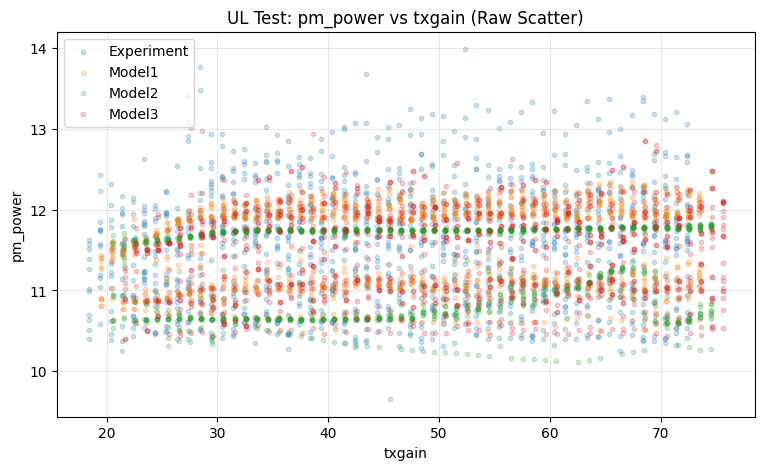

UL Test: pm_power vs txgain (Raw Scatter)
Total points plotted (raw): 1158
[Model1] MSE=0.2153 RMSE=0.4640 MAE=0.3612 MRE=3.11%
[Model2] MSE=0.3101 RMSE=0.5568 MAE=0.4129 MRE=3.48%
[Model3] MSE=0.2615 RMSE=0.5114 MAE=0.3827 MRE=3.26%


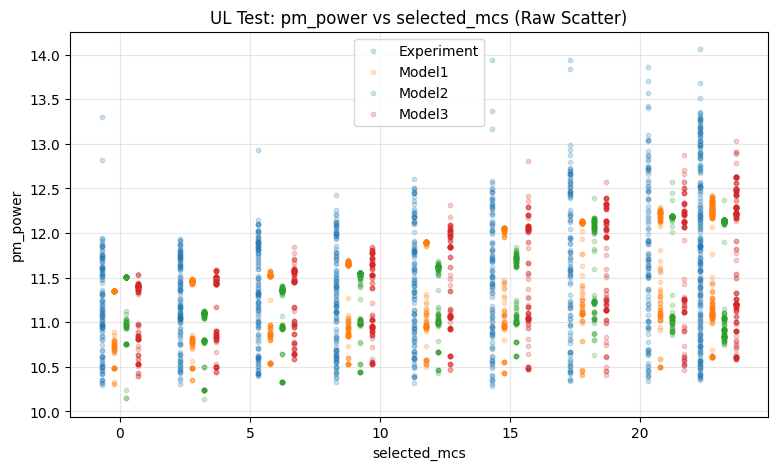

UL Test: pm_power vs selected_mcs (Raw Scatter)
Total points plotted (raw): 1156
[Model1] MSE=0.2164 RMSE=0.4652 MAE=0.3546 MRE=3.03%
[Model2] MSE=0.2672 RMSE=0.5169 MAE=0.4034 MRE=3.44%
[Model3] MSE=0.2321 RMSE=0.4818 MAE=0.3604 MRE=3.09%


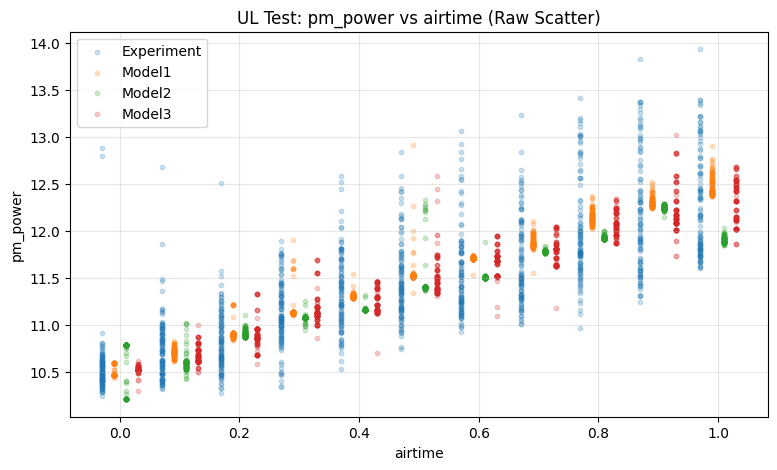

UL Test: pm_power vs airtime (Raw Scatter)
Total points plotted (raw): 1159
[Model1] MSE=0.2048 RMSE=0.4525 MAE=0.3493 MRE=3.01%
[Model2] MSE=0.2274 RMSE=0.4769 MAE=0.3604 MRE=3.08%
[Model3] MSE=0.1927 RMSE=0.4389 MAE=0.3335 MRE=2.86%


In [20]:
# ============================================================
# RAW SCATTER PLOTTING (NO MEAN AGGREGATION)
# Experiment + Model1 + Model2 + Model3
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


# ------------------------------------------------------------
# 1) Metric utilities
# ------------------------------------------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    """
    Compute Mean Relative Error (percentage).
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)


def compute_metrics(y_true, y_pred):
    """
    Compute MSE, RMSE, MAE, MRE.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mre = mean_relative_error(y_true, y_pred)
    return mse, rmse, mae, mre


# ------------------------------------------------------------
# 2) Build unified raw test DataFrame (NO averaging)
# ------------------------------------------------------------
def build_raw_test_dataframe(
    feat_name,
    xcol,
    test_outputs_m1,
    test_outputs_m2,
    test_outputs_m3
):
    """
    Construct a single DataFrame for plotting raw results.

    IMPORTANT:
    We assume that y_true and predictions are aligned with test_df row order.
    """

    df_base = test_outputs_m1[feat_name]["test_df"].copy()

    df_plot = pd.DataFrame({
        xcol: df_base[xcol].values,
        "y_true": test_outputs_m1[feat_name]["y_true"],
        "y_pred_m1": test_outputs_m1[feat_name]["y_pred_m1"],
        "y_pred_m2": test_outputs_m2[feat_name]["y_pred_m2"],
        "y_pred_m3": test_outputs_m3[feat_name]["y_pred_m3"],
    })

    df_plot = df_plot.dropna().copy()
    return df_plot


# ------------------------------------------------------------
# 3) Raw scatter plot with horizontal separation
# ------------------------------------------------------------
def plot_raw_scatter_with_offset(
    df_plot,
    xcol,
    title,
    max_points=60000,
    seed=42,
    offset_fraction=0.03,
    point_size=10,
    alpha=0.25
):
    """
    Plot raw scatter WITHOUT any mean aggregation.

    To visually separate experiment and model predictions,
    we apply a small deterministic horizontal offset.

    offset_fraction controls how much separation relative to x-range.
    """

    d = df_plot.copy()

    # Optional downsampling for performance
    if len(d) > max_points:
        d = d.sample(n=max_points, random_state=seed).copy()

    d = d.sort_values(xcol)

    x = d[xcol].to_numpy()

    # Determine offset scale relative to x-range
    x_min, x_max = np.min(x), np.max(x)
    x_range = max(x_max - x_min, 1e-9)
    dx = offset_fraction * x_range

    # Fixed offsets for visual clarity
    offsets = {
        "exp": -1.5 * dx,
        "m1":  -0.5 * dx,
        "m2":   0.5 * dx,
        "m3":   1.5 * dx,
    }

    # Compute metrics
    m1 = compute_metrics(d["y_true"], d["y_pred_m1"])
    m2 = compute_metrics(d["y_true"], d["y_pred_m2"])
    m3 = compute_metrics(d["y_true"], d["y_pred_m3"])

    # --------------------------------------------------------
    # Plot
    # --------------------------------------------------------
    plt.figure(figsize=(9, 5))

    # Raw experiment points
    plt.scatter(
        x + offsets["exp"],
        d["y_true"],
        s=point_size,
        alpha=alpha,
        label="Experiment"
    )

    # Model predictions
    plt.scatter(
        x + offsets["m1"],
        d["y_pred_m1"],
        s=point_size,
        alpha=alpha,
        label="Model1"
    )

    plt.scatter(
        x + offsets["m2"],
        d["y_pred_m2"],
        s=point_size,
        alpha=alpha,
        label="Model2"
    )

    plt.scatter(
        x + offsets["m3"],
        d["y_pred_m3"],
        s=point_size,
        alpha=alpha,
        label="Model3"
    )

    plt.xlabel(xcol)
    plt.ylabel("pm_power")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.show()

    # --------------------------------------------------------
    # Print metrics summary
    # --------------------------------------------------------
    print("=" * 60)
    print(title)
    print(f"Total points plotted (raw): {len(d)}")
    print(f"[Model1] MSE={m1[0]:.4f} RMSE={m1[1]:.4f} MAE={m1[2]:.4f} MRE={m1[3]:.2f}%")
    print(f"[Model2] MSE={m2[0]:.4f} RMSE={m2[1]:.4f} MAE={m2[2]:.4f} MRE={m2[3]:.2f}%")
    print(f"[Model3] MSE={m3[0]:.4f} RMSE={m3[1]:.4f} MAE={m3[2]:.4f} MRE={m3[3]:.2f}%")
    print("=" * 60)


# ------------------------------------------------------------
# 4) Generate plots for gain / mcs / airtime
# ------------------------------------------------------------

PLOT_CONFIG = {
    "gain":   ("txgain", "UL Test: pm_power vs txgain (Raw Scatter)"),
    "mcs":    ("selected_mcs", "UL Test: pm_power vs selected_mcs (Raw Scatter)"),
    "airtime":("airtime", "UL Test: pm_power vs airtime (Raw Scatter)"),
}

for feat_name, (xcol, title) in PLOT_CONFIG.items():

    df_plot = build_raw_test_dataframe(
        feat_name=feat_name,
        xcol=xcol,
        test_outputs_m1=test_outputs_m1,
        test_outputs_m2=test_outputs_m2,
        test_outputs_m3=test_outputs_m3
    )

    plot_raw_scatter_with_offset(
        df_plot=df_plot,
        xcol=xcol,
        title=title,
        max_points=100000,      # adjust if needed
        offset_fraction=0.02,  # increase if still overlapping
        point_size=10,
        alpha=0.22
    )


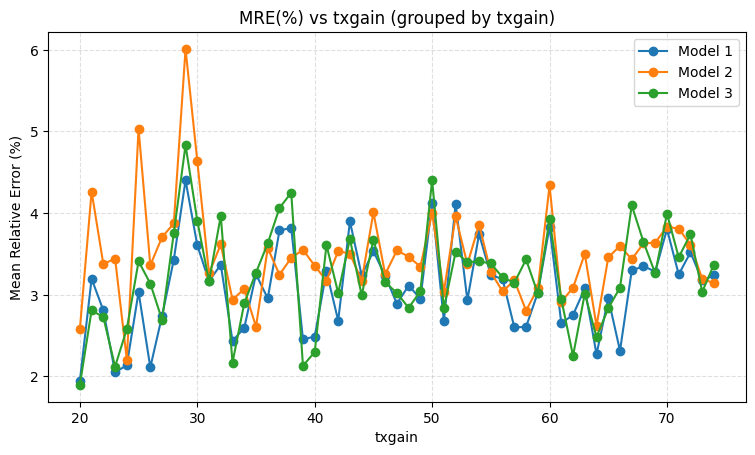

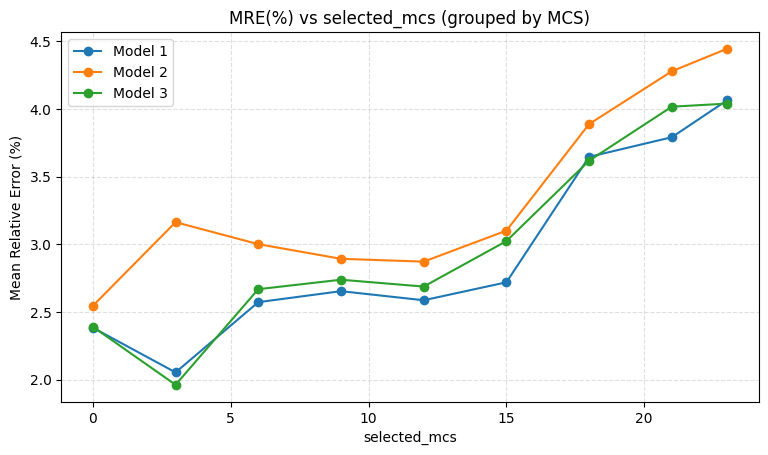

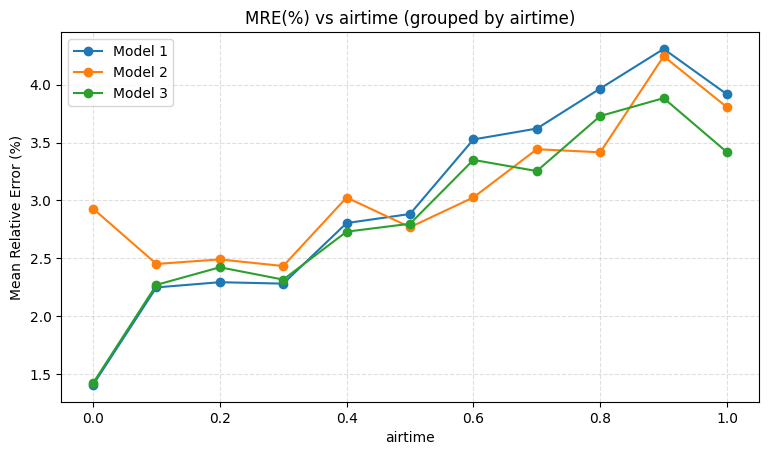

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# 1) Row-wise relative error
# ------------------------------------------------------------
def row_relative_error(y_true, y_pred, eps=1e-9):
    """
    Per-sample relative error (not averaged yet).
    RE_i = |y_true - y_pred| / (|y_true| + eps)
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.abs(y_true - y_pred) / (np.abs(y_true) + eps)


# ------------------------------------------------------------
# 2) Build a unified test DataFrame for a given feature set
#    (raw y_true + predictions + xcol)
# ------------------------------------------------------------
def build_raw_test_df_for_mre(
    feat_name, xcol,
    test_outputs_m1, test_outputs_m2, test_outputs_m3
):
    """
    Create a DataFrame with columns:
      xcol, y_true, y_pred_m1, y_pred_m2, y_pred_m3
    """
    base = test_outputs_m1[feat_name]["test_df"].copy()

    df_plot = pd.DataFrame({
        xcol: base[xcol].values,
        "y_true": test_outputs_m1[feat_name]["y_true"],
        "y_pred_m1": test_outputs_m1[feat_name]["y_pred_m1"],
        "y_pred_m2": test_outputs_m2[feat_name]["y_pred_m2"],
        "y_pred_m3": test_outputs_m3[feat_name]["y_pred_m3"],
    })

    df_plot = df_plot.dropna().copy()
    return df_plot


# ------------------------------------------------------------
# 3) Compute MRE(%) grouped by xcol
# ------------------------------------------------------------
def compute_group_mre_curves(df_plot, xcol):
    """
    For each unique x value:
      - compute mean relative error (%) for each model
    Returns a DataFrame:
      xcol, mre_m1, mre_m2, mre_m3
    """
    d = df_plot.copy()

    # Per-sample relative errors
    d["re_m1"] = row_relative_error(d["y_true"], d["y_pred_m1"])
    d["re_m2"] = row_relative_error(d["y_true"], d["y_pred_m2"])
    d["re_m3"] = row_relative_error(d["y_true"], d["y_pred_m3"])

    # Group by x and take mean relative error within each x bin/value
    g = (
        d.groupby(xcol)[["re_m1", "re_m2", "re_m3"]]
        .mean()
        .reset_index()
        .sort_values(xcol)
        .rename(columns={
            "re_m1": "mre_m1",
            "re_m2": "mre_m2",
            "re_m3": "mre_m3",
        })
    )

    # Convert to percentage
    g["mre_m1"] *= 100
    g["mre_m2"] *= 100
    g["mre_m3"] *= 100

    return g


# ------------------------------------------------------------
# 4) Plot MRE curves (3 lines like your example)
# ------------------------------------------------------------
def plot_mre_curves(g, xcol, title):
    """
    Plot 3 MRE(%) curves: Model1/Model2/Model3
    """
    plt.figure(figsize=(9, 4.8))

    plt.plot(g[xcol], g["mre_m1"], marker="o", label="Model 1")
    plt.plot(g[xcol], g["mre_m2"], marker="o", label="Model 2")
    plt.plot(g[xcol], g["mre_m3"], marker="o", label="Model 3")

    plt.xlabel(xcol)
    plt.ylabel("Mean Relative Error (%)")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()


# ------------------------------------------------------------
# 5) Generate the 3 MRE plots (gain / mcs / airtime)
# ------------------------------------------------------------
MRE_PLOT_CONFIG = {
    "gain":   ("txgain", "MRE(%) vs txgain (grouped by txgain)"),
    "mcs":    ("selected_mcs", "MRE(%) vs selected_mcs (grouped by MCS)"),
    "airtime":("airtime", "MRE(%) vs airtime (grouped by airtime)"),
}

for feat_name, (xcol, title) in MRE_PLOT_CONFIG.items():
    df_plot = build_raw_test_df_for_mre(
        feat_name=feat_name,
        xcol=xcol,
        test_outputs_m1=test_outputs_m1,
        test_outputs_m2=test_outputs_m2,
        test_outputs_m3=test_outputs_m3
    )

    g = compute_group_mre_curves(df_plot, xcol=xcol)

    plot_mre_curves(g, xcol=xcol, title=title)


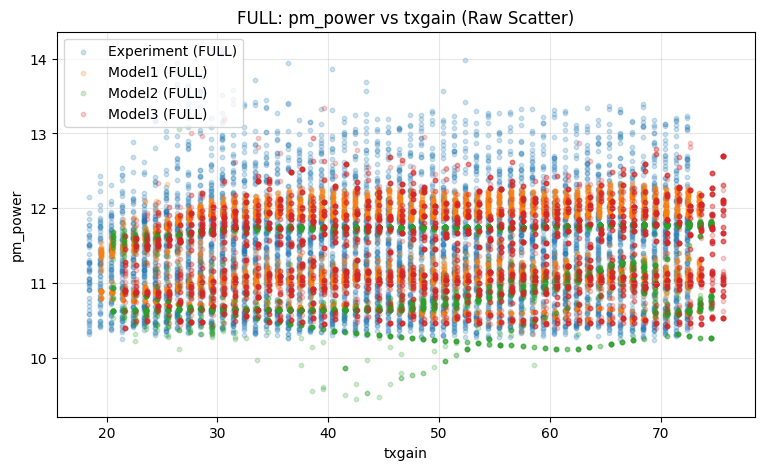

FULL: pm_power vs txgain (Raw Scatter)
Total FULL points plotted: 5769
[Model1] MSE=0.2577 RMSE=0.5076 MAE=0.3989 MRE=3.45%
[Model2] MSE=0.3431 RMSE=0.5858 MAE=0.4427 MRE=3.77%
[Model3] MSE=0.2257 RMSE=0.4751 MAE=0.3540 MRE=3.03%


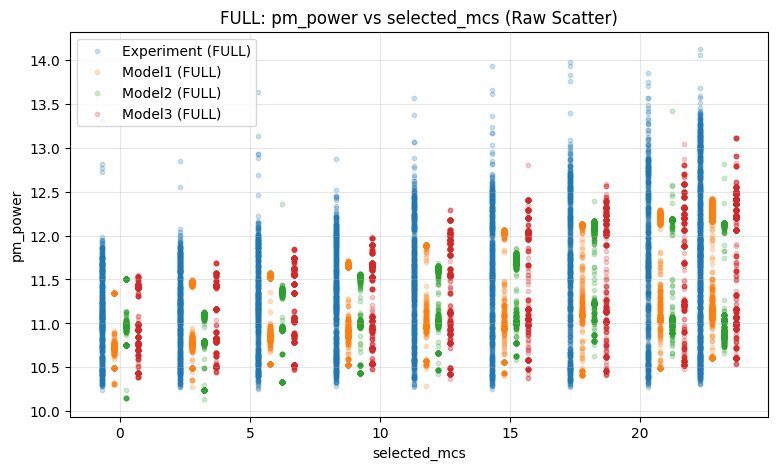

FULL: pm_power vs selected_mcs (Raw Scatter)
Total FULL points plotted: 5769
[Model1] MSE=0.1965 RMSE=0.4433 MAE=0.3400 MRE=2.92%
[Model2] MSE=0.2464 RMSE=0.4964 MAE=0.3886 MRE=3.34%
[Model3] MSE=0.1953 RMSE=0.4419 MAE=0.3334 MRE=2.87%


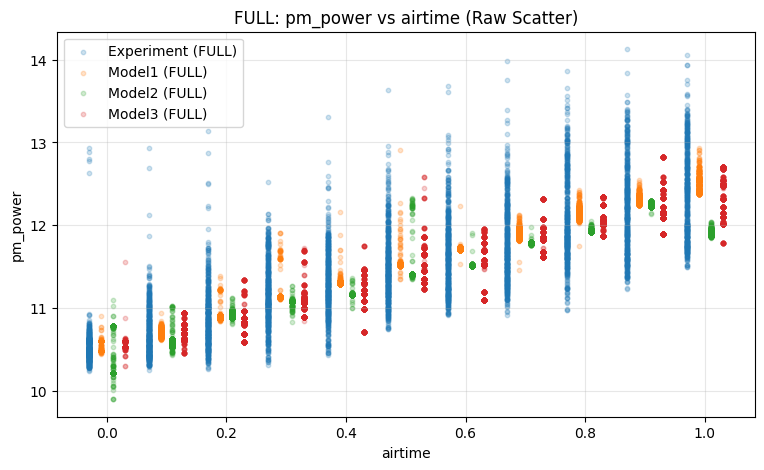

FULL: pm_power vs airtime (Raw Scatter)
Total FULL points plotted: 5769
[Model1] MSE=0.1839 RMSE=0.4289 MAE=0.3308 MRE=2.84%
[Model2] MSE=0.2185 RMSE=0.4675 MAE=0.3522 MRE=3.00%
[Model3] MSE=0.1860 RMSE=0.4313 MAE=0.3239 MRE=2.77%


In [26]:
# ============================================================
# RAW SCATTER PLOTTING (NO MEAN AGGREGATION) — FULL DATASET
# Experiment (FULL) + Model1/2/3 predictions on FULL dataset
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

# ------------------------------------------------------------
# 0) Load FULL dataset
# ------------------------------------------------------------
full_df = pd.read_csv("clean_ul_with_conditions2.csv")

# Ensure numeric
for c in ["pm_power","txgain","selected_mcs","airtime","traffic_load","BW","nRBs","clockspeed"]:
    if c in full_df.columns:
        full_df[c] = pd.to_numeric(full_df[c], errors="coerce")

# OPTIONAL: force bins to make vertical columns (recommended)
# Uncomment if you want guaranteed "columns"
full_df["txgain"] = full_df["txgain"].round(0).astype(int)
full_df["selected_mcs"] = full_df["selected_mcs"].round(0).astype(int)
full_df["airtime"] = full_df["airtime"].round(1)

# ------------------------------------------------------------
# 1) Metric utilities (same as yours)
# ------------------------------------------------------------
def mean_relative_error(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + eps)) * 100)

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    mre = mean_relative_error(y_true, y_pred)
    return mse, rmse, mae, mre

# ------------------------------------------------------------
# 2) FULL prediction helpers
# ------------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

def predict_full_pytorch(df_in, feature_cols, scaler, model, device="cpu"):
    X = df_in[feature_cols].to_numpy()
    Xs = scaler.transform(X)
    model.eval()
    with torch.no_grad():
        xt = torch.tensor(Xs, dtype=torch.float32).to(device)
        yhat = model(xt).cpu().numpy().reshape(-1)
    return yhat

def predict_full_hybrid(df_in, feature_cols, scaler, dnn, xgb, device="cpu"):
    X = df_in[feature_cols].to_numpy()
    Xs = scaler.transform(X)
    dnn.eval()
    with torch.no_grad():
        xt = torch.tensor(Xs, dtype=torch.float32).to(device)
        _, emb = dnn(xt)
        emb = emb.cpu().numpy()
    return xgb.predict(emb).reshape(-1)

# ------------------------------------------------------------
# 3) Build unified raw FULL DataFrame (NO averaging)
# ------------------------------------------------------------
def build_raw_full_dataframe(feat_name, xcol, full_df, FEATURE_SETS, trained_models):
    """
    Build a FULL dataset plotting DataFrame:
      xcol, y_true (pm_power), y_pred_m1/m2/m3 (FULL predictions)
    """
    feature_cols = FEATURE_SETS[feat_name]

    cols_needed = feature_cols + ["pm_power"]
    d = full_df[cols_needed].dropna().copy()

    # Fetch trained model objects (per feature set)
    m1 = trained_models[feat_name]["m1"]
    m2 = trained_models[feat_name]["m2"]
    m3 = trained_models[feat_name]["m3"]

    # FULL predictions
    d["y_pred_m1"] = predict_full_pytorch(d, feature_cols, m1["scaler"], m1["model"], device=device)
    d["y_pred_m2"] = predict_full_pytorch(d, feature_cols, m2["scaler"], m2["model"], device=device)
    d["y_pred_m3"] = predict_full_hybrid(d, feature_cols, m3["scaler"], m3["dnn"], m3["xgb"], device=device)

    # Rename target to match your plotting function
    d = d.rename(columns={"pm_power": "y_true"}).copy()

    # Keep only what we need
    df_plot = d[[xcol, "y_true", "y_pred_m1", "y_pred_m2", "y_pred_m3"]].dropna().copy()
    return df_plot

# ------------------------------------------------------------
# 4) Your plotting function (unchanged)
# ------------------------------------------------------------
def plot_raw_scatter_with_offset(
    df_plot,
    xcol,
    title,
    max_points=60000,
    seed=42,
    offset_fraction=0.03,
    point_size=10,
    alpha=0.25
):
    d = df_plot.copy()

    # Optional downsampling for performance
    if len(d) > max_points:
        d = d.sample(n=max_points, random_state=seed).copy()

    d = d.sort_values(xcol)

    x = pd.to_numeric(d[xcol], errors="coerce").to_numpy()

    # Determine offset scale relative to x-range
    x_min, x_max = np.nanmin(x), np.nanmax(x)
    x_range = max(x_max - x_min, 1e-9)
    dx = offset_fraction * x_range

    offsets = {"exp": -1.5*dx, "m1": -0.5*dx, "m2": 0.5*dx, "m3": 1.5*dx}

    # Metrics
    m1 = compute_metrics(d["y_true"], d["y_pred_m1"])
    m2 = compute_metrics(d["y_true"], d["y_pred_m2"])
    m3 = compute_metrics(d["y_true"], d["y_pred_m3"])

    plt.figure(figsize=(9, 5))
    plt.scatter(x + offsets["exp"], d["y_true"],    s=point_size, alpha=alpha, label="Experiment (FULL)")
    plt.scatter(x + offsets["m1"],  d["y_pred_m1"], s=point_size, alpha=alpha, label="Model1 (FULL)")
    plt.scatter(x + offsets["m2"],  d["y_pred_m2"], s=point_size, alpha=alpha, label="Model2 (FULL)")
    plt.scatter(x + offsets["m3"],  d["y_pred_m3"], s=point_size, alpha=alpha, label="Model3 (FULL)")

    plt.xlabel(xcol)
    plt.ylabel("pm_power")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    print("=" * 60)
    print(title)
    print(f"Total FULL points plotted: {len(d)}")
    print(f"[Model1] MSE={m1[0]:.4f} RMSE={m1[1]:.4f} MAE={m1[2]:.4f} MRE={m1[3]:.2f}%")
    print(f"[Model2] MSE={m2[0]:.4f} RMSE={m2[1]:.4f} MAE={m2[2]:.4f} MRE={m2[3]:.2f}%")
    print(f"[Model3] MSE={m3[0]:.4f} RMSE={m3[1]:.4f} MAE={m3[2]:.4f} MRE={m3[3]:.2f}%")
    print("=" * 60)

# ------------------------------------------------------------
# 5) Generate plots (FULL)
# ------------------------------------------------------------
PLOT_CONFIG = {
    "gain":   ("txgain", "FULL: pm_power vs txgain (Raw Scatter)"),
    "mcs":    ("selected_mcs", "FULL: pm_power vs selected_mcs (Raw Scatter)"),
    "airtime":("airtime", "FULL: pm_power vs airtime (Raw Scatter)"),
}

for feat_name, (xcol, title) in PLOT_CONFIG.items():
    df_plot = build_raw_full_dataframe(
        feat_name=feat_name,
        xcol=xcol,
        full_df=full_df,
        FEATURE_SETS=FEATURE_SETS,
        trained_models=trained_models
    )

    plot_raw_scatter_with_offset(
        df_plot=df_plot,
        xcol=xcol,
        title=title,
        max_points=120000,     # increase if you want denser plots
        offset_fraction=0.02,
        point_size=10,
        alpha=0.22
    )
